In [469]:
import numpy as np
import pandas as pd

# read data
train_dir = r'C:\Users\10415\Desktop\TSF\train.csv'
train = pd.read_csv(train_dir)
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [470]:
# read holidays
holidays_dir = r'C:\Users\10415\Desktop\TSF\holidays_events.csv'
holidays = pd.read_csv(holidays_dir)
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [471]:
# read oil
oil_dir = r'C:\Users\10415\Desktop\TSF\oil.csv'
oil = pd.read_csv(oil_dir)
oil.head()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [472]:
# read stores
stores_dir = r'C:\Users\10415\Desktop\TSF\stores.csv'
stores = pd.read_csv(stores_dir)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [473]:
# read transactions
transactions_dir = r'C:\Users\10415\Desktop\TSF\transactions.csv'
transactions = pd.read_csv(transactions_dir)
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [474]:
# read test
test_dir = r'C:\Users\10415\Desktop\TSF\test.csv'
test = pd.read_csv(test_dir)
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


FEATURE ENGINEERING:
target: sales/ each day/ each store/ per family
features: lag and lead onpromotion(C), lag sales(C)(T), store transactions per day(C), store type, wages paid(S), holiday(S)

In [475]:
# visualize store 1 sales vs time on these families: AUTOMOTIVE	BABY CARE	BEAUTY	BEVERAGES	BOOKS 
import matplotlib.pyplot as plt
import seaborn as sns
store1 = train[train['store_nbr'] == 1]
store1 = store1.set_index('date')
store1.index = pd.to_datetime(store1.index)
store1 = store1.sort_index()
store1 = store1[['family','sales']]
store1 = store1[store1['family'].isin(['AUTOMOTIVE','BABY CARE','BEAUTY','BEVERAGES','BOOKS'])]
# index by family
store1 = store1.reset_index()
store1 = store1.set_index(['family','date'])
store1 = store1.sort_index()
store1 = store1.fillna(0)



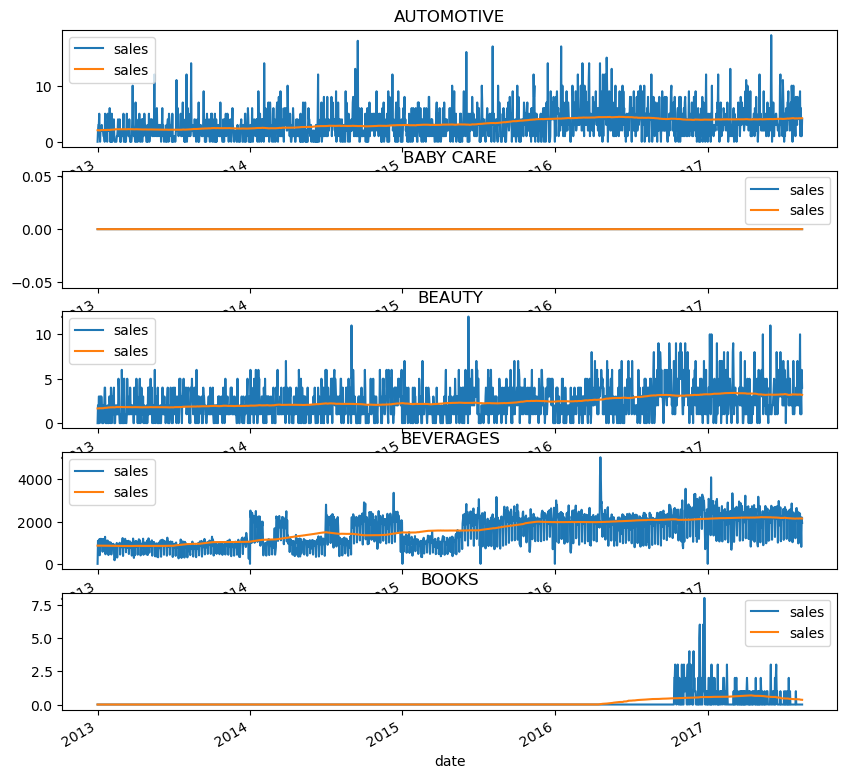

In [476]:
# create moving average plot for each family above, using rolling windows of 365 days
families = store1.index.levels[0]
fig, axes = plt.subplots(len(families),1,figsize=(10,10))
for i,family in enumerate(families):
    store1.loc[family].plot(ax=axes[i],title=family)
    store1.loc[family].rolling(window=365, center = True, min_periods=183).mean().plot(ax=axes[i],title=family)



This analyse seasonality

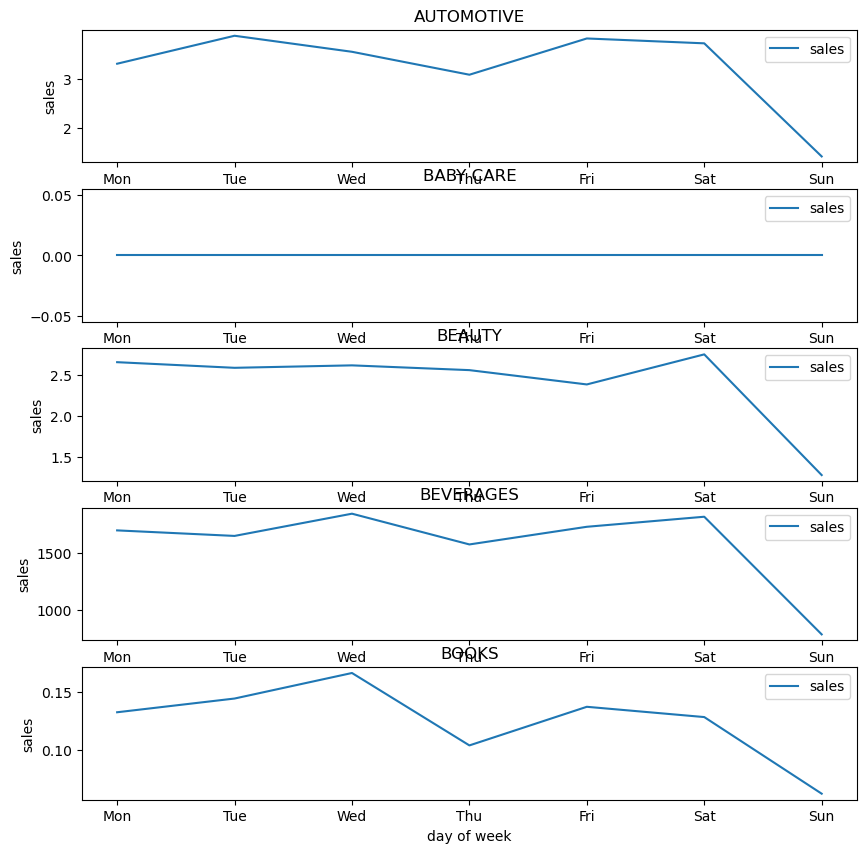

In [477]:
# copy store1 to store1_ma
store1_ma = store1.copy()


fig, axes = plt.subplots(len(families),1,figsize=(10,10))
# make a seasonal plot weekly by adding a dummy indicator for each day of the week, then plot sale vs day of the week
store1_ma['day_of_week'] = store1_ma.index.get_level_values(1).dayofweek
store1_ma['day_of_week'] = store1_ma['day_of_week'].astype('category')
store1_ma['day_of_week'] = store1_ma['day_of_week'].cat.rename_categories(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])



for i,family in enumerate(families):
    store1_ma.loc[family].groupby('day_of_week').mean().plot(ax=axes[i],title=family)
    axes[i].set_ylabel('sales')
    axes[i].set_xlabel('day of week')




Creat periodogram to confirm seasonality

C:\Users\10415\AppData\Local\Temp\ipykernel_51676\1999041387.py:40: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, amplitudes, use_line_collection=True)


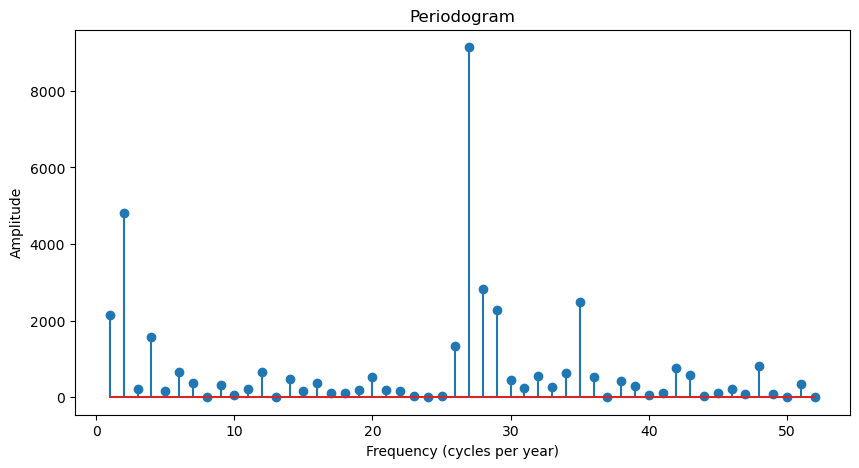

Top 5 frequencies: [32 43 34 12  6 42 48 26  4  1 29 35 28  2 27]


In [478]:
store2 = store1.copy()
# create fourier features from once per year to 52 times per year, then fit them to a linear model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

cata = ['AUTOMOTIVE','BABY CARE','BEAUTY','BEVERAGES','BOOKS']

automotive_data = store2.loc[cata[3]]
automotive_data['time'] = np.arange(len(automotive_data))

n_pairs = 52

# Prepare columns for cosine and sine
cos_cols = {f'cos_{k}': np.cos(2 * np.pi * k * automotive_data['time'] / 365.25) for k in range(1, n_pairs + 1)}
sin_cols = {f'sin_{k}': np.sin(2 * np.pi * k * automotive_data['time'] / 365.25) for k in range(1, n_pairs + 1)}

new_cols = pd.DataFrame({**cos_cols, **sin_cols})

automotive_data = pd.concat([automotive_data, new_cols], axis=1)


# columns for regression
feature_cols = [f for f in automotive_data.columns if 'cos_' in f or 'sin_' in f]

# fit the linear model
X = automotive_data[feature_cols]
y = automotive_data['sales']

model = LinearRegression()
model.fit(X, y)

coefficients = model.coef_

# compute the amplitude of each frequency
amplitudes = (coefficients[0::2]**2 + coefficients[1::2]**2)/2

# create a periodogram
frequencies = np.arange(1, n_pairs + 1)
plt.figure(figsize=(10, 5))
plt.stem(frequencies, amplitudes, use_line_collection=True)
plt.title('Periodogram')
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.show()

# remove the frequencies is 52
amplitudes[51] = 0

# print the frequencies that are top 5
top_5 = np.argsort(amplitudes)[-15:]
print(f'Top 5 frequencies: {frequencies[top_5]}')



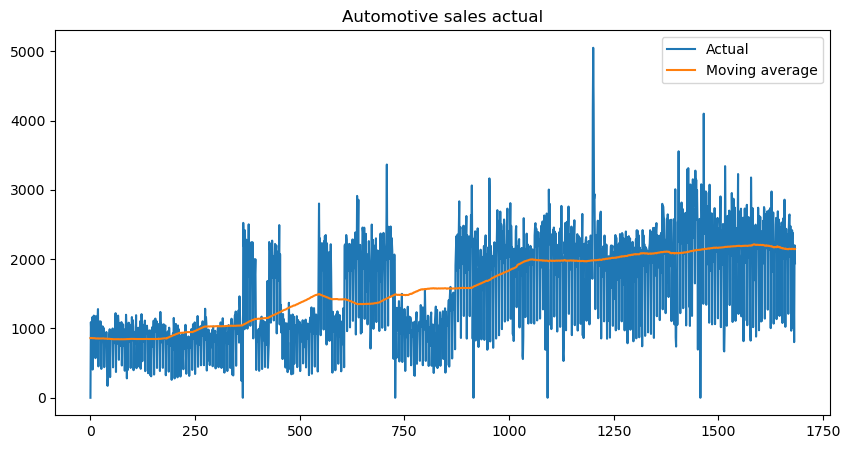

In [479]:
# plot the entire sequence of automotive sales vs time
# calculate a moving average of 365 days and plot it

ma = automotive_data['sales'].rolling(window=365, center=True, min_periods=183).mean()

plt.figure(figsize=(10, 5))
plt.plot(automotive_data['time'], automotive_data['sales'])
plt.plot(automotive_data['time'], ma)
plt.title('Automotive sales actual')
plt.legend(['Actual', 'Moving average'])


Index(['cos_32', 'cos_43', 'cos_34', 'cos_12', 'cos_6', 'cos_42', 'cos_48',
       'cos_26', 'cos_4', 'cos_1', 'cos_29', 'cos_35', 'cos_28', 'cos_2',
       'cos_27', 'sin_32', 'sin_43', 'sin_34', 'sin_12', 'sin_6', 'sin_42',
       'sin_48', 'sin_26', 'sin_4', 'sin_1', 'sin_29', 'sin_35', 'sin_28',
       'sin_2', 'sin_27', 'time', 'time_2', 'time_3', 'bias'],
      dtype='object')


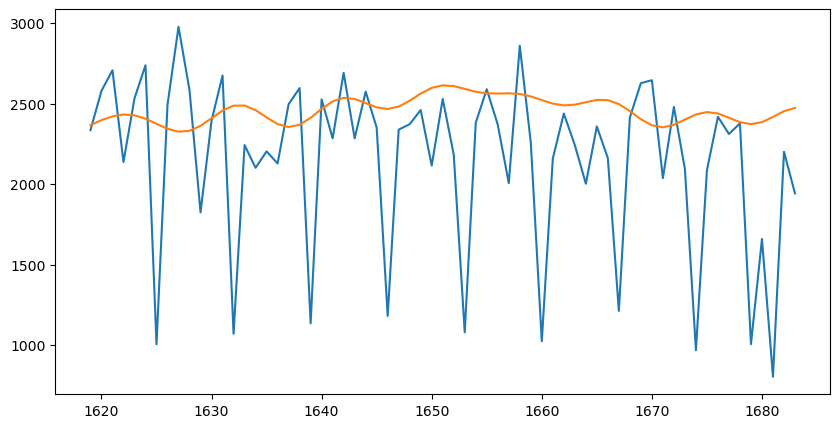

In [480]:
# keep only the top 5 frequencies and sort them

chosen_f_cols = [f'cos_{f}' for f in frequencies[top_5]] + [f'sin_{f}' for f in frequencies[top_5]]

# add time and bias
# make X as a copy of automotive_data
X = automotive_data.copy()
X = X[chosen_f_cols]

# add time and bias to count for trend
X.loc[:,'time'] = automotive_data['time'].values
X.loc[:,'time_2'] = automotive_data['time'].values**2
X.loc[:,'time_3'] = automotive_data['time'].values**3
X.loc[:,'bias'] = 1

print(X.columns)
model = LinearRegression()
model.fit(X.iloc[:-65], y.iloc[:-65])

# plot prediction vs actual training data
plt.figure(figsize=(10, 5))
# only plot the time of last 365 days
plt.plot(automotive_data['time'].iloc[-65:], y.iloc[-65:], label='actual')
plt.plot(automotive_data['time'].iloc[-65:], model.predict(X.iloc[-65:]), label='predicted')





In [481]:

# one hot encode the day of the week and fit a linear model with the original data
# add columns for each date in data


model_2 = LinearRegression()
X = automotive_data.drop(columns=['sales'])

Xx = X[chosen_f_cols]
# take the set difference of the between X and Xx
X = X.drop(columns=set(X.columns) - set(Xx.columns))

X['day_of_week'] = X.index.day_of_week
X = pd.get_dummies(X, columns=['day_of_week'])
X['time'] = np.arange(len(X))
X['time_2'] = X['time']**2
X['time_3'] = X['time']**3
X['bias'] = 1

# read holidays_events.csv and create dummy variables for each national and regional holiday, if for a holiday that is "transferred" to another day, use the day it is transferred to, and set the original day to 0
holidays_dir = r'C:\Users\10415\Desktop\TSF\holidays_events.csv'
holidays = pd.read_csv(holidays_dir)
holidays = holidays.set_index('date')
holidays.index = pd.to_datetime(holidays.index)
holidays = (
    holidays
    .query("locale in ['National', 'Regional']")
    .loc[:, ['description', 'type', 'transferred']]
)
# remove rows that transferred is true
holidays['transferred'] = holidays['transferred'].astype(bool)
holidays = holidays[holidays['transferred'] == False]
holidays['type'] = holidays['type'].astype('category')
holidays = holidays[holidays['type'].isin(['Holiday', 'Transfer'])]
# if type is transfer, remove the Traslado in the description
holidays['description'] = holidays['description'].str.replace('Traslado ', '')
# create dummy variables for each holiday as categorical
holidays = pd.get_dummies(holidays['description'])
# save the holidays to a csv file
display(holidays)
holidays.fillna(0)
# merge the holidays with X
X = X.join(holidays)


print(X.columns)
y=automotive_data['sales']
X2 = X.iloc[:-65]
y2 = y.iloc[:-65]
model_2.fit(X2, y2)

# plot prediction vs actual training data
plt.figure(figsize=(10, 5))
# only plot the time of last 365 days
plt.plot(automotive_data['time'].iloc[-65:], y.iloc[-65:], label='actual')
plt.plot(automotive_data['time'].iloc[-65:], model_2.predict(X.iloc[-65:]), label='predicted')
plt.legend()




,Batalla de Pichincha,Carnaval,Dia de Difuntos,Dia del Trabajo,Independencia de Cuenca,Independencia de Guayaquil,Navidad,Primer Grito de Independencia,Primer dia del ano,Provincializacion Santa Elena,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo,Viernes Santo
date,,,,,,,,,,,,,,
2012-04-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2012-06-25,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2012-08-10,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2012-10-12,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2012-11-02,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-02,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-11-03,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-11-06,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Index(['cos_1', 'cos_2', 'cos_4', 'cos_6', 'cos_12', 'cos_26', 'cos_27',
       'cos_28', 'cos_29', 'cos_32', 'cos_34', 'cos_35', 'cos_42', 'cos_43',
       'cos_48', 'sin_1', 'sin_2', 'sin_4', 'sin_6', 'sin_12', 'sin_26',
       'sin_27', 'sin_28', 'sin_29', 'sin_32', 'sin_34', 'sin_35', 'sin_42',
       'sin_43', 'sin_48', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'time', 'time_2', 'time_3', 'bias', 'Batalla de Pichincha', 'Carnaval',
       'Dia de Difuntos', 'Dia del Trabajo', 'Independencia de Cuenca',
       'Independencia de Guayaquil', 'Navidad',
       'Primer Grito de Independencia', 'Primer dia del ano',
       'Provincializacion Santa Elena', 'Provincializacion de Cotopaxi',
       'Provincializacion de Imbabura', 'Provincializacion de Santo Domingo',
       'Viernes Santo'],
      dtype='object')


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

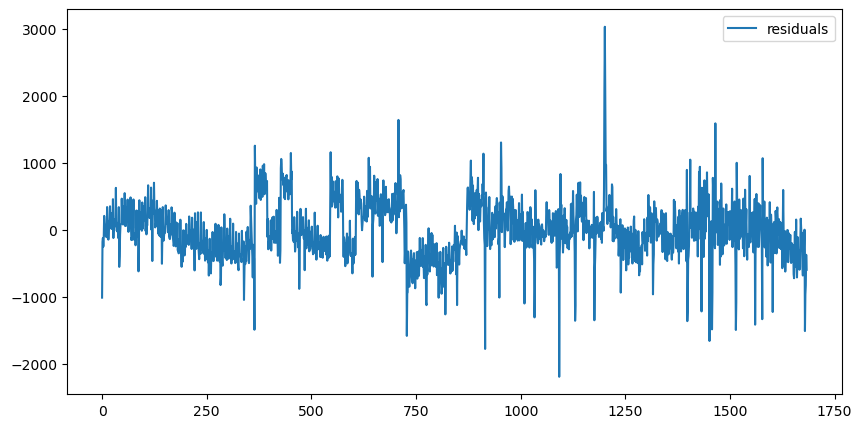

In [ ]:
# deseaonlize the data at entire length
# then plot residuals 
y_pred = model_2.predict(X)
residuals = y - y_pred
plt.figure(figsize=(10, 5))
plt.plot(automotive_data['time'], residuals)
plt.legend(['residuals'])

In [ ]:
# calculate residual average
residual_avg = residuals.mean()
print(f'Residual average: {residual_avg}')

''' should be close to zero'''

# calculate residual MSE
residual_mse = (residuals**2).mean()
print(f'Residual MSE: {residual_mse}')

''' should be lower than the variance of the data'''

# calculate data MSE
data_mse = ((y - y.mean())**2).mean()
print(f'Data MSE: {data_mse}')

''' should be higher than the residual MSE'''


Residual average: -11.975320737930888
Residual MSE: 177241.7394955418
Data MSE: 528026.3377361192


' should be higher than the residual MSE'

Deal with the residual with xgboost, taking y lag, promo today lead and lag, oil today and lag,

In [ ]:
#